In [381]:
import os
import h5py
import json

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn, tanh, relu
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

import pyknos.nflows as nflows
from merger_tree_ml import utils
from merger_tree_ml import transforms as T

%matplotlib inline

plt.style.use('/mnt/home/tnguyen/mplstyle/latex_plot_style.mplstyle')

## Define path and hyparameters

In [391]:
hparams_fn = "/mnt/home/tnguyen/merger_tree_ml/config/hparams.json"
hparams = json.load(open(hparams_fn, 'r'))
transform_hparams = hparams['transform_hparams']
transform_hparams['TruncateTree']['max_length'] = 30

print(transform_hparams)
transform = T.Transform(transform_hparams)

dataset_name = 'GUREFT_90/MADE_v1'
train_path = utils.io_utils.get_dataset(dataset_name, train=True)
val_path = utils.io_utils.get_dataset(dataset_name, train=False)

{'order': ['ToTensor', 'TruncateTree', 'LogTransform', 'StandardScaler'], 'ToTensor': {'dtype': 'float32'}, 'TruncateTree': {'max_length': 30, 'pad_value': None}, 'LogTransform': {'dims': 0}, 'StandardScaler': {'axis': [0, 1]}}


## Read in dataset and apply preprocessing transformation

In [392]:
train_features, _, _ = utils.io_utils.read_ds(train_path)
val_features, _, _ = utils.io_utils.read_ds(val_path)

# Preprocess dataset
train_features_ts = transform(train_features, train=True)
val_features_ts = transform(val_features, train=False)
train_features_ts = train_features_ts[..., 0]
val_features_ts = val_features_ts[..., 0]

train_features_ts = train_features_ts[torch.all(torch.diff(train_features_ts) < 0, 1)]
val_features_ts = val_features_ts[torch.all(torch.diff(val_features_ts) < 0, 1)]

# Create dataset
max_epochs = 1000
batch_size = 256
train_ds = TensorDataset(train_features_ts)
val_ds = TensorDataset(val_features_ts)
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    pin_memory=True if torch.cuda.is_available() else False
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    pin_memory=True if torch.cuda.is_available() else False
)

In [340]:
class MergerTreeMAF(pl.LightningModule):
    
    def __init__(
        self, features, hidden_features, context_features, num_blocks):
        
        super().__init__()
        self.save_hyperparameters()
        self.features = features
        
        # Create normalizing flow
        transform = nflows.transforms.MaskedAffineAutoregressiveTransform(
            features, hidden_features, 
            context_features=context_features, 
            num_blocks=num_blocks,
            activation=tanh,
            use_batch_norm=True,
        )
        distribution = nflows.distributions.StandardNormal((features,))
        self.maf = nflows.flows.Flow(transform, distribution)
        
        
    def configure_optimizers(self):
        """ Initialize optimizer and LR scheduler """
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-4)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, 'min', patience=4),
                'monitor': 'train_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }
        
    def forward(self, x):
        return x
        
    def training_step(self, batch, batch_idx):
        x = batch[0]
        y = utils.torch_utils.inverse_softplus(-torch.diff(x)) 
        log_prob = self.maf.log_prob(y, context=x[...,:1])
        loss = -log_prob.mean()
        self.log('train_loss', loss, on_epoch=True, batch_size=len(x))
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        y = utils.torch_utils.inverse_softplus(-torch.diff(x)) 
        log_prob = self.maf.log_prob(y, context=x[...,:1])
        loss = -log_prob.mean()
        self.log('val_loss', loss, on_epoch=True, batch_size=len(x))
        return loss

## Train MAF to estimate $\Delta (\log_{10} M)$

In [341]:
run_prefix = "/mnt/home/tnguyen/ceph/log"
run_name = "MAF_GUREFT90_D20"

model = MergerTreeMAF(
    features=train_features_ts.shape[1]-1, hidden_features=32,
    context_features=1, num_blocks=4)

In [342]:
trainer = pl.Trainer(
    default_root_dir=os.path.join(run_prefix, run_name),
    accelerator="cpu",
    devices=1,
    max_epochs=max_epochs,
    logger=CSVLogger(
        run_prefix, name=run_name, version=0),
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            filename="{epoch}-{val_loss:.4f}", save_weights_only=True,
            mode="min", monitor="val_loss"),
        pl.callbacks.LearningRateMonitor("epoch"),
        pl.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss", min_delta=0.00, patience=10,
            mode="min", verbose=True),
    ],
    enable_progress_bar=True
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/tnguyen/venvs/torch-tree/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1766: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [230]:
# Start training
trainer.fit(
    model=model, train_dataloaders=train_loader,
    val_dataloaders=val_loader)


  | Name | Type | Params
------------------------------
0 | maf  | Flow | 12.2 K
------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/mnt/home/tnguyen/venvs/torch-tree/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/tnguyen/venvs/torch-tree/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/tnguyen/venvs/torch-tree/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1894: PossibleUserWarning: The number of training batches (6) is smaller t

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 121.230


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.981 >= min_delta = 0.0. New best score: 108.248


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.820 >= min_delta = 0.0. New best score: 98.428


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.244 >= min_delta = 0.0. New best score: 91.184


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.454 >= min_delta = 0.0. New best score: 85.730


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.362 >= min_delta = 0.0. New best score: 81.368


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.565 >= min_delta = 0.0. New best score: 77.803


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.988 >= min_delta = 0.0. New best score: 74.815


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.577 >= min_delta = 0.0. New best score: 72.237


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.228 >= min_delta = 0.0. New best score: 70.009


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.961 >= min_delta = 0.0. New best score: 68.048


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.745 >= min_delta = 0.0. New best score: 66.303


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.594 >= min_delta = 0.0. New best score: 64.709


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.461 >= min_delta = 0.0. New best score: 63.248


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.336 >= min_delta = 0.0. New best score: 61.912


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.276 >= min_delta = 0.0. New best score: 60.637


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.202 >= min_delta = 0.0. New best score: 59.435


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.158 >= min_delta = 0.0. New best score: 58.276


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.115 >= min_delta = 0.0. New best score: 57.161


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.066 >= min_delta = 0.0. New best score: 56.095


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.035 >= min_delta = 0.0. New best score: 55.060


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.022 >= min_delta = 0.0. New best score: 54.038


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.980 >= min_delta = 0.0. New best score: 53.058


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.948 >= min_delta = 0.0. New best score: 52.110


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.926 >= min_delta = 0.0. New best score: 51.184


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.896 >= min_delta = 0.0. New best score: 50.288


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.836 >= min_delta = 0.0. New best score: 49.452


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.810 >= min_delta = 0.0. New best score: 48.642


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.791 >= min_delta = 0.0. New best score: 47.851


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.788 >= min_delta = 0.0. New best score: 47.063


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.716 >= min_delta = 0.0. New best score: 46.347


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.680 >= min_delta = 0.0. New best score: 45.667


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.632 >= min_delta = 0.0. New best score: 45.035


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.606 >= min_delta = 0.0. New best score: 44.428


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.575 >= min_delta = 0.0. New best score: 43.853


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.567 >= min_delta = 0.0. New best score: 43.286


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.529 >= min_delta = 0.0. New best score: 42.756


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.449 >= min_delta = 0.0. New best score: 42.308


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.445 >= min_delta = 0.0. New best score: 41.863


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.396 >= min_delta = 0.0. New best score: 41.468


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.367 >= min_delta = 0.0. New best score: 41.101


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.353 >= min_delta = 0.0. New best score: 40.747


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.319 >= min_delta = 0.0. New best score: 40.429


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.288 >= min_delta = 0.0. New best score: 40.141


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.291 >= min_delta = 0.0. New best score: 39.849


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.247 >= min_delta = 0.0. New best score: 39.602


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.221 >= min_delta = 0.0. New best score: 39.381


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.213 >= min_delta = 0.0. New best score: 39.168


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.205 >= min_delta = 0.0. New best score: 38.963


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 38.790


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.171 >= min_delta = 0.0. New best score: 38.619


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 38.449


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 38.293


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 38.144


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 38.022


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 37.878


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 37.796


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 37.652


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 37.561


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 37.442


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 37.353


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 37.273


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.117 >= min_delta = 0.0. New best score: 37.156


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 37.088


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 36.986


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 36.907


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 36.828


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 36.747


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 36.665


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 36.597


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 36.516


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 36.469


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 36.373


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 36.326


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 36.245


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 36.167


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 36.138


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 36.053


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 35.994


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 35.944


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 35.864


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 35.786


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 35.763


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 35.697


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 35.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 35.587


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 35.511


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 35.489


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 35.414


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 35.362


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 35.325


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 35.263


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 35.220


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 35.185


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 35.105


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 35.054


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 35.023


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 34.991


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 34.909


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 34.865


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 34.846


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 34.768


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 34.753


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 34.695


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 34.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 34.594


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 34.560


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 34.519


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 34.487


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 34.436


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 34.423


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 34.359


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 34.335


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 34.265


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 34.229


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 34.220


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 34.168


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 34.133


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 34.126


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 34.072


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 34.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 33.989


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 33.977


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 33.952


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 33.886


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 33.854


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 33.818


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 33.766


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 33.760


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 33.718


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 33.694


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 33.686


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 33.657


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 33.594


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 33.547


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 33.516


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 33.502


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 33.485


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 33.452


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 33.420


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 33.370


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 33.326


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 33.303


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 33.298


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 33.288


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 33.267


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 33.205


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 33.181


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 33.173


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 33.162


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 33.134


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 33.113


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 33.073


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 33.059


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 33.058


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 33.032


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 32.998


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 32.984


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 32.967


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 32.871


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 32.865


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 32.845


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 32.828


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 32.791


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 32.769


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 32.752


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 32.739


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 32.727


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 32.706


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 32.679


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 32.677


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 32.668


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 32.618


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 32.616


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 32.591


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 32.591. Signaling Trainer to stop.


## Load model and sample trees

In [393]:
# model = MergerTreeMAF.load_from_checkpoint(
#     trainer.checkpoint_callbacks[0].best_model_path)
# model = MergerTreeMAF.load_from_checkpoint(
#     '/mnt/home/tnguyen/ceph/log/MAF_GUREFT90_D10/version_0/checkpoints/epoch=174-val_loss=9.7880.ckpt')
# model = MergerTreeMAF.load_from_checkpoint(
#     '/mnt/home/tnguyen/ceph/log/MAF_GUREFT90_D20/version_0/checkpoints/epoch=171-val_loss=20.7240.ckpt')
model = MergerTreeMAF.load_from_checkpoint(
    '/mnt/home/tnguyen/ceph/log/MAF_GUREFT90_D30/version_0/checkpoints/epoch=211-val_loss=32.5907.ckpt')
scaler = transform[3]

In [394]:
def sample_trees(model, log_mass_ini, num_samples, to_numpy=True):
    model.eval()
    with torch.no_grad():
        # conver log mass into tensor and preprocess
        x = torch.tensor(log_mass_ini, dtype=torch.float32).view(-1, 1)
        x = scaler.transform(x, dim=0)
        
        # sample Delta log M
        dx = model.maf.sample(num_samples, context=x).squeeze()
        dx = -F.softplus(dx)
        
        # compute log M and prepend root mass to array
        x_pred = x + torch.cumsum(dx, -1)
        x_repeat = torch.repeat_interleave(x, num_samples).view(num_samples, 1)
        x_pred = torch.hstack([x_repeat, x_pred])
        
        # inverse transform to mass
        x_pred = scaler.inverse(x_pred, dim=0) 

    if to_numpy:
        x_pred = x_pred.cpu().numpy()
    return x_pred

In [399]:
num_samples = 1000
z = train_features[0][:30, 1]
dz = z - z[0]

In [400]:
trees_m105 = sample_trees(model, 10.5, num_samples)
trees_m110 = sample_trees(model, 11, num_samples)
trees_m115 = sample_trees(model, 11.5, num_samples)
trees_m120 = sample_trees(model, 12, num_samples)

In [401]:
features_ts = torch.cat([train_features_ts, val_features_ts], 0)
log_mass = scaler.inverse(features_ts, 0)
log_mass = log_mass.cpu().numpy()
log_mass_ini = log_mass[..., 0]

log_mass_ini_mid = [10.5, 11, 11.5, 12]
log_mass_ini_wid = [0.1, 0.1, 0.1, 0.5]

trees_gureft = []

for i in range(len(log_mass_ini_mid)):
    log_mass_lo = log_mass_ini_mid[i] - log_mass_ini_wid[i]
    log_mass_hi = log_mass_ini_mid[i] + log_mass_ini_mid[i]
    
    trees_gureft.append(log_mass[(log_mass_lo <= log_mass_ini) & (log_mass_ini <= log_mass_hi)])

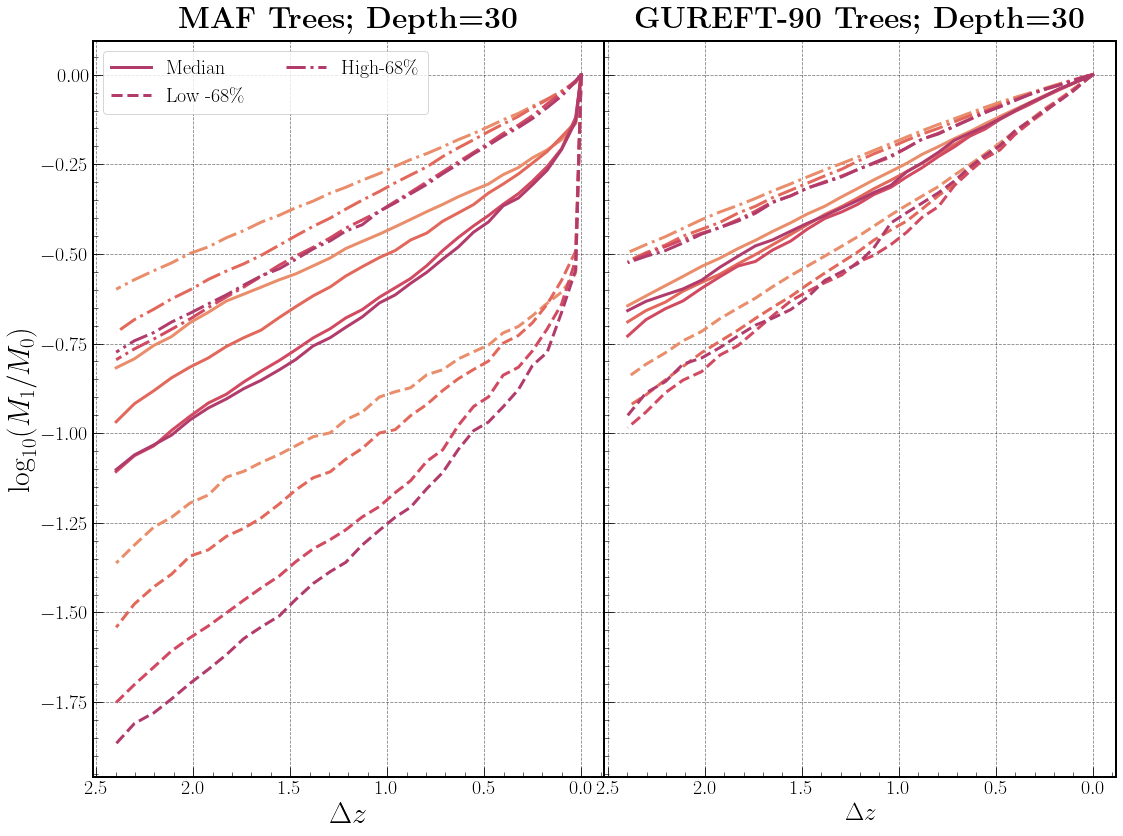

In [402]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)

colors = sns.color_palette("flare")

ax = axes[0]
for i, trees in enumerate([trees_m105, trees_m110, trees_m115, trees_m120]):
    lo, med, hi = np.percentile(trees, [16, 50, 84], 0)
    lme = ax.plot(dz, med - med[0], color=colors[i], lw=3)
    llo = ax.plot(dz, lo-lo[0], color=colors[i], ls='--', lw=3)
    lhi = ax.plot(dz, hi-hi[0], color=colors[i], ls='-.', lw=3)

ax = axes[1]
for i, trees in enumerate(trees_gureft):
    lo, med, hi = np.percentile(
        trees - trees[:, 0].reshape(-1, 1), [16, 50, 84], 0)
    lme = ax.plot(dz, med, color=colors[i], lw=3)
    llo = ax.plot(dz, lo, color=colors[i], ls='--', lw=3)
    lhi = ax.plot(dz, hi, color=colors[i], ls='-.', lw=3)
    
    
axes[0].set_ylabel(r'$\log_{10} (M_1 / M_0)$', fontsize=30)
axes[0].set_xlabel(r'$\Delta z$', fontsize=30)
axes[0].set_title(r'\bf MAF Trees; Depth=30', fontsize=30, y=1.01)
    
axes[1].set_xlabel(r'$\Delta z$', fontsize=25)
axes[1].set_title(r'\bf GUREFT-90 Trees; Depth=30', fontsize=30, y=1.01)
    
for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='major', ls='--', color='k', alpha=0.5)
axes[0].invert_xaxis()
axes[0].legend(
    [lme[0], llo[0], lhi[0]], ['Median', 'Low -68\%', 'High-68\%'],
    ncol=2, loc=2
)

fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.savefig('notebooks/figures/maf_gureft90_d30.pdf', dpi=600, bbox_inches='tight')

In [354]:
# fig, ax = plt.subplots(figsize=(8, 12))

# colors = sns.color_palette("flare")

# for i, trees in enumerate([trees_m105, trees_m110, trees_m115, trees_m120]):

#     lo, med, hi = np.percentile(trees, [16, 50, 84], 0)
#     lme = ax.plot(dz, med - med[0], color=colors[i], lw=3)
#     llo = ax.plot(dz, lo-lo[0], color=colors[i], ls='--', lw=3)
#     lhi = ax.plot(dz, hi-hi[0], color=colors[i], ls='-.', lw=3)

# ax.invert_xaxis()
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax.grid(which='major', ls='--', color='k', alpha=0.5)
# ax.set_ylabel(r'$\log_{10} (M_1 / M_0)$', fontsize=25)
# ax.set_xlabel(r'$\Delta z$', fontsize=25)
# ax.set_title(r'\bf MAF Trees; Depth=30', fontsize=30, y=1.01)


# ax.legend([lme[0], llo[0], lhi[0]], ['Median', 'Low -68\%', 'High-68\%'])

# fig.tight_layout()
# fig.savefig('notebooks/figures/maf_d30.pdf', dpi=600, bbox_inches='tight')

In [355]:
# fig, ax = plt.subplots(figsize=(8, 12))

# colors = sns.color_palette("flare")

# for i, trees in enumerate(trees_gureft):
#     lo, med, hi = np.percentile(trees, [16, 50, 84], 0)
#     lme = ax.plot(dz, med - med[0], color=colors[i], lw=3)
#     llo = ax.plot(dz, lo-lo[0], color=colors[i], ls='--', lw=3)
#     lhi = ax.plot(dz, hi-hi[0], color=colors[i], ls='-.', lw=3)

# ax.invert_xaxis()
# ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax.grid(which='major', ls='--', color='k', alpha=0.5)
# ax.set_ylabel(r'$\log_{10} (M_1 / M_0)$', fontsize=25)
# ax.set_xlabel(r'$\Delta z$', fontsize=25)
# ax.set_title(r'\bf GUREFT-90 Trees; Depth=30', fontsize=30, y=1.01)


# ax.legend([lme[0], llo[0], lhi[0]], ['Median', 'Low -68\%', 'High-68\%'])

# fig.tight_layout()
# fig.savefig('notebooks/figures/gureft90_d30.pdf', dpi=600, bbox_inches='tight')